# Wine Price Prediction on Kaggle Dataset

The aim is to predict wine prices from mixed inputs that contain both textual and categorical data. For this regression problem several neural based model were trained and their results have been discussed. The models make use of pretrained [Glove](https://nlp.stanford.edu/projects/glove/) vectors of 100 dimentions. Hence, the glove.6B.100d needs to be downloaded in order to run the training and evaluation parts. Numpy, pandas, scikit learn and nltk was used for data manupulation and pre processing. Keras was used to build and train the machine learning models. 

Several different approaches were tried for this problem.

## Model 1 (One Model)

The first model makes use of pretrained word embeddings to come up with a representation of the wine descriptions in the datasets. For each description an average vector representation is constructed by averaging all the word vectors available in the description. Hence, a 100 dimention feature representation of the description column was obtained with such an approach. The intuition is that the word order might not be important since this is not a sequence to sequence problem and using an averaged representation would be sufficient for the description semantics. Additionally, the tf-idf values of each word in the descriptions were found so that the text can be vectorized in terms of tf-idf values. These, tf-idf vector representations and also average embedding vector representations were combined with several other categorical features that are selected from the dataset directly and then given to a neural network to learn the underlying regression function.  

## Model 2 (Multi Model)

The second model differs from the first model in the sense that the features are not given to the neural network by directly concatanating them. There are three different models making use of different features and these models are being concatanated in the end to make the final wine price prediction. For instance, vector average representations, tf-idf vector representation and categorical features obtained from the dataset are seperately fed into three different neural networks. Then, each of the outputs of these neural network contribute to the prediction of the wine price seperately. 

## Model 3 (LSTM Multi Model)

The last model is almost identical to the second model. The only part where it differs is that the vector average representation is replaced with an LSTM that learns the representation of the description within the model using pretrained Glove embeddings. Again description representation, tf-idf feature and categorical features contribute to the prediction of wine price seperately. 




## Load Pretrained Glove vectors

Please give the correct path for Glove embeddings and wine dataset csv.
Additionally, I have used Google Colabs to train the models. Hence, I commented those lines of codes in case it is executed in a different environment.

In [1]:
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import keras, nltk, string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from google.colab import drive
#from google.colab import files

# This will prompt for authorization. 
#drive.mount('/content/drive')

# Setup NLTK packages if not present
nltk.download("punkt")
nltk.download("stopwords")
   
  
# Helper funtion for loading Glove embeddings
def load_glove(glove_path):
    embeddings_index = {}
    f = open(glove_path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index


# Params
GLOVE_PATH = "glove.6B.100d.txt"
DATA_PATH = "winemag-data-130k-v2.csv"
EMBEDDING_FEATS_PATH = "embedding_feats.csv"
GLOVE_EMBED_SIZE = 100 
LOAD_EMBEDDING_FEATS = False

# Load glove embeddings
embeddings=load_glove(GLOVE_PATH)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load the data to Pandas and select the features to be used

In [2]:
# Load data to pandas data frame
data = pd.read_csv(DATA_PATH)

# Show the general information regarding the dataset
data.info()

# Only select the columns that might be needed for the regression task
data=data[['country','description','points','price','province','region_1','variety']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


## Data Preprocessing

First the data is checked column-wise to see the missing value percantages per column. None of the selected columns are exceeding the threshold of %50 missing instances, hence no need to eliminate any columns.

The second step is to reduce the dimentionality of the categorical input representations by eliminating the instances that have frequencies below a certain threshold. The threshold were selected empirically by trial and error that aimed to keep the most of the training data but also reduce the dimentionality as much as possible so that the model can learn the problem easier.

After the eliminations 22933 instance, we are left with a total of 107038 instances.

In [3]:
initial_size=len(data)
print("Initial data size: ",initial_size)

# Print the percentage of NaNs that each column has in training data for analysis
print(data.isnull().sum(axis=0)/len(data))

# Define a threshold for dropping the columns with NaN percent above a certain threshold
threshold=0.5

# Drop the columns exceeding the threshold
columns_drop=data.columns[data.isnull().sum(axis=0)/len(data)>threshold]
data=data.drop(columns_drop,axis=1)

# Do some preprocessing to eliminate rows that have frequency below some threshold
# This operation is only applied to variety, region and province to reduce the feature input size
# The threshold values are selected after empiracally trying several numbers
variety_threshold = 100 
#region_threshold = 0 
province_threshold = 10 

# Set the values below certain threshold as NaN
variety_counts = data['variety'].value_counts()
remove_variety = variety_counts[variety_counts <= variety_threshold].index
data.replace(remove_variety, np.nan, inplace=True)

#region_counts = data['region_1'].value_counts()
#remove_region = region_counts[region_counts <= region_threshold].index
#data.replace(remove_region, np.nan, inplace=True)

province_counts = data['province'].value_counts()
remove_province = province_counts[province_counts <= province_threshold].index
data.replace(remove_province, np.nan, inplace=True)

# Eliminate the rows with NaN values and reset the dataframe index for further use
data.dropna(subset=['variety','country','price','province'],inplace=True)
data.reset_index(inplace=True,drop=True)

print("Resulting data size: ",len(data), "\nNumber of eliminated instances: ",initial_size-len(data))

data.head(10)

Initial data size:  129971
country        0.000485
description    0.000000
points         0.000000
price          0.069215
province       0.000485
region_1       0.163475
variety        0.000008
dtype: float64
Resulting data size:  107038 
Number of eliminated instances:  22933


,country,description,points,price,province,region_1,variety
0,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Pinot Gris
1,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Riesling
2,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Pinot Noir
3,France,This dry and restrained wine offers spice in p...,87,24.0,Alsace,Alsace,Gewürztraminer
4,Germany,Savory dried thyme notes accent sunnier flavor...,87,12.0,Rheinhessen,NaN,Gewürztraminer
5,France,This has great depth of flavor with its fresh ...,87,27.0,Alsace,Alsace,Pinot Gris
6,US,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Napa Valley,Cabernet Sauvignon
7,France,"This is a dry wine, very spicy, with a tight, ...",87,30.0,Alsace,Alsace,Gewürztraminer
8,US,"Slightly reduced, this wine offers a chalky, t...",87,34.0,California,Alexander Valley,Cabernet Sauvignon
9,US,Building on 150 years and six generations of w...,87,12.0,California,Central Coast,Chardonnay


## Average Vector Representation of Descriptions

As explained earlier, Glove word embedding are utilized to come up with a  100 dimentional representation for each description in the dataset. Hence, these embeddings are averaged and the obtained vectors are saved as a seperate dataframe to be fed into the neural networks as features later on. Each  description is tokenized and then cleaned by eliminating the stopwords and lowercasing the tokens. Then, the lookups are made to the Glove embeddings dictionary. 

### This process can take slightly long amount of time.

In [4]:
# Define cosine similarity for measuring the similarity between average Glove vector representation of descriptions
def cosine_sim(a,b):
    dot = np.dot(a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return cos

# Choose whether to load a previously extracted average embedding feature file or extract them now
if LOAD_EMBEDDING_FEATS:
  print("Loading embedding features from file: ", EMBEDDING_FEATS_PATH)
  embedding_feats = pd.read_csv(EMBEDDING_FEATS_PATH)
  embedding_feats.drop(embedding_feats.columns[0],axis=1,inplace=True)
else:
  # Select the descriptions from dataframe and create an initial numpy array that will hold average vector per description
  descriptions=data['description']
  desc_avg_vecs=np.zeros((1,100))

  total_processed=0
  print(len(descriptions))
  for description in descriptions:
      # Clean the description by eliminating stop words, punctuations and lowercasing the text
      desc_clean = [i for i in nltk.word_tokenize(description.lower()) if i not in list(string.punctuation)+nltk.corpus.stopwords.words('english')]

      # Define a numpy array for summing up each word vector within description
      sum_vec=np.zeros(100)
      count=0
      for word in desc_clean:
          if word in embeddings:
              sum_vec=np.add(sum_vec,embeddings[word])
              count+=1

      # Add the averaged vector of the current description    
      desc_avg_vecs=np.vstack((desc_avg_vecs,sum_vec/count))

      # For tracking the progress
      total_processed+=1
      if(total_processed%1000==0):
          print("Average Glove vector progress: ",100*total_processed/len(descriptions))

  desc_avg_vecs=desc_avg_vecs[1:]

  # Cosine similarity of two descriptions
  print(data['description'].iloc[3])
  print(data['description'].iloc[7])
  print("Cosine similarity between descriptions: ", cosine_sim(desc_avg_vecs[3],desc_avg_vecs[7]))

  # Load the description average vector features to a dataframe for future use
  embedding_feats=pd.DataFrame(desc_avg_vecs)

  # Save the embedding features to csv
  embedding_feats.to_csv(EMBEDDING_FEATS_PATH)

# Resulting feature size of descriptions
print("Embedding features shape: ", embedding_feats.shape)

107038
Average Glove vector progress:  0.9342476503671593
Average Glove vector progress:  1.8684953007343186
Average Glove vector progress:  2.802742951101478
Average Glove vector progress:  3.736990601468637
Average Glove vector progress:  4.671238251835796
Average Glove vector progress:  5.605485902202956
Average Glove vector progress:  6.539733552570115
Average Glove vector progress:  7.473981202937274
Average Glove vector progress:  8.408228853304434
Average Glove vector progress:  9.342476503671593
Average Glove vector progress:  10.276724154038753
Average Glove vector progress:  11.210971804405911
Average Glove vector progress:  12.145219454773072
Average Glove vector progress:  13.07946710514023
Average Glove vector progress:  14.01371475550739
Average Glove vector progress:  14.947962405874549
Average Glove vector progress:  15.882210056241709
Average Glove vector progress:  16.81645770660887
Average Glove vector progress:  17.750705356976027
Average Glove vector progress:  18.

## Extract TF-IDF Features and convert Categorical Attributes to One-Hot Vectors

For categorical attributes, country, province, variety and points were used since the other columns (taster name, twitter, handle) seemed irrelvant or had a lot of missing values (region_2, region_3) or increased the input dimentionality which is not desired when predicting the wine prices.

In [5]:
# Extract tf-idf features from the descriptions
vectorizer = TfidfVectorizer(stop_words='english',ngram_range =(1,1),max_features=10000)
tf_idf_feats = vectorizer.fit_transform(data['description'])

# Use sklearn utility to convert label strings to numbered index
columns_to_encode=['country','province','variety','points']
le = LabelEncoder()
data.loc[:,columns_to_encode]=data.loc[:, columns_to_encode].apply(le.fit_transform)

country_num_classes = np.max(data['country']) + 1
province_num_classes = np.max(data['province']) + 1
variety_num_classes = np.max(data['variety']) + 1
points_num_classes = np.max(data['points']) + 1

# Convert labels to one hot
country_feats = keras.utils.to_categorical(data['country'], country_num_classes)
province_feats = keras.utils.to_categorical(data['province'], province_num_classes)
variety_feats = keras.utils.to_categorical(data['variety'], variety_num_classes)
points_feats = keras.utils.to_categorical(data['points'], points_num_classes)

print("Embeddings features shape: ", embedding_feats.shape,
      "\ntf-idf feature shape: ", tf_idf_feats.shape,
      "\nvariety feature shape: ", variety_feats.shape,
      "\nprovince feature shape: ", province_feats.shape,
      "\ncountry feature shape: ", country_feats.shape, 
      "\npoints feature shape: ", points_feats.shape)


Embeddings features shape:  (107038, 100) 
tf-idf feature shape:  (107038, 10000) 
variety feature shape:  (107038, 88) 
province feature shape:  (107038, 166) 
country feature shape:  (107038, 24) 
points feature shape:  (107038, 21)


## Split the data into Train and Test sets 

In [6]:
# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

# Train features
embedding_feats_train = embedding_feats[:train_size]
tf_idf_feats_train = tf_idf_feats[:train_size]
variety_feats_train = variety_feats[:train_size]
province_feats_train = province_feats[:train_size]
country_feats_train = country_feats[:train_size]
points_feats_train = points_feats[:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
embedding_feats_test = embedding_feats[train_size:]
tf_idf_feats_test = tf_idf_feats[train_size:]
variety_feats_test = variety_feats[train_size:]
province_feats_test = province_feats[train_size:]
country_feats_test = country_feats[train_size:]
points_feats_test = points_feats[train_size:]

# Test labels
labels_test = data['price'][train_size:]

Train size: 85630
Test size: 21408


## Prepare the input data for the LSTM part of Model 3

The description text is preprocessed by making use of Keras tokenizer. Then the tokenized text is converted into sequences. Importantly padding is applied with respect to the longest sequence in the data. Lastly, an embedding matrix that only contains the words ids and their Glove vector representations is created to initialize the Embedding layer of the LSTM of Model 3.  

In [0]:
# Method required for making use of pretrained embeddings in LSTM embedding layer
def prepare_embedding_weights(word2id,embedding_size, glove_embeddings):
  embedding_matrix = np.zeros((len(word2id) + 1, embedding_size))
  for word, i in word2id.items():
      embedding_vector = glove_embeddings.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

  return embedding_matrix


# Create a Keras tokenizer to preprocess descriptions
desc_train = data['description'][:train_size]
desc_test = data['description'][train_size:]

# Limit the max vocab size
MAX_VOCAB_SIZE = 15000

# Tokenize and fit on training text
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE, char_level=False)
tokenizer.fit_on_texts(data['description'][:train_size])

# Convert tokenized text to padded sequences for LSTM
train_seqs = tokenizer.texts_to_sequences(desc_train)
test_seqs = tokenizer.texts_to_sequences(desc_test)

# Find the max sequence length in the corpus in order to pad with correct length
MAX_SEQ_LEN = max(len(max(train_seqs, key=len)),len(max(test_seqs, key=len)))
train_seqs_padded = keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=MAX_SEQ_LEN, padding="post")
test_seqs_padded = keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=MAX_SEQ_LEN, padding="post")

# Form the embedding layers weight matrix from pretrained Glove vectors
embedding_matrix = prepare_embedding_weights(tokenizer.word_index, GLOVE_EMBED_SIZE, embeddings)

## Models



In [0]:
# Model 1
def create_one_model():
  # Input layer
  embed_inputs = keras.layers.Input(shape=(embedding_feats.shape[1],))
  tf_idf_inputs = keras.layers.Input(shape=(tf_idf_feats.shape[1],))
  variety_inputs = keras.layers.Input(shape=(variety_feats.shape[1],))
  province_inputs = keras.layers.Input(shape=(province_feats.shape[1],))
  country_inputs = keras.layers.Input(shape=(country_feats.shape[1],))
  points_inputs = keras.layers.Input(shape=(points_feats.shape[1],))

  # Hidden Layer
  concat_input_layer = keras.layers.concatenate([embed_inputs, tf_idf_inputs, variety_inputs,province_inputs, country_inputs, points_inputs])
  concat_input_layer = keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(concat_input_layer)

  #Output layer
  output = keras.layers.Dense(1,activation='linear')(concat_input_layer)
  model = keras.Model(inputs=[embed_inputs,tf_idf_inputs, variety_inputs,province_inputs, country_inputs, points_inputs], outputs=output)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  print(model.summary())
  
  return model

# Model 2
def create_multi_model():
  # Input layer
  embed_inputs = keras.layers.Input(shape=(embedding_feats.shape[1],))
  tf_idf_inputs = keras.layers.Input(shape=(tf_idf_feats.shape[1],))
  variety_inputs = keras.layers.Input(shape=(variety_feats.shape[1],))
  province_inputs = keras.layers.Input(shape=(province_feats.shape[1],))
  country_inputs = keras.layers.Input(shape=(country_feats.shape[1],))
  points_inputs = keras.layers.Input(shape=(points_feats.shape[1],))
  
  # Embedding model
  embed_layer_1 = keras.layers.Dense(32, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(embed_inputs)
  embed_layer_2 = keras.layers.Dense(1, activation="linear")(embed_layer_1)
  embed_model = keras.Model(inputs=embed_inputs, outputs=embed_layer_2)

  # tf-idf model
  tf_idf_layer_1 = keras.layers.Dense(32, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(tf_idf_inputs)
  tf_idf_layer_2 = keras.layers.Dense(1, activation="linear")(tf_idf_layer_1)
  tf_idf_model = keras.Model(inputs=tf_idf_inputs, outputs=tf_idf_layer_2)

  # Categorical features model
  categorical_input_layer = keras.layers.concatenate([variety_inputs,province_inputs, country_inputs, points_inputs])
  categorical_layer_1 = keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(categorical_input_layer)
  categorical_layer_2 = keras.layers.Dense(1, activation='linear')(categorical_layer_1)
  categorical_model = keras.Model(inputs=[variety_inputs,province_inputs, country_inputs, points_inputs], outputs=categorical_layer_2)

  combined = keras.layers.concatenate([embed_model.output, tf_idf_model.output, categorical_model.output])
  output = keras.layers.Dense(1, activation="linear")(combined)
  model = keras.Model(inputs=[embed_inputs,tf_idf_inputs, variety_inputs,province_inputs, country_inputs, points_inputs], outputs=output)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  print(model.summary())
  
  return model

# Model 3
def create_lstm_multi_model():
  hidden_size=32
  vocab_size=embedding_matrix.shape[0]
  
  # Input layer
  tf_idf_inputs = keras.layers.Input(shape=(tf_idf_feats.shape[1],))
  variety_inputs = keras.layers.Input(shape=(variety_feats.shape[1],))
  province_inputs = keras.layers.Input(shape=(province_feats.shape[1],))
  country_inputs = keras.layers.Input(shape=(country_feats.shape[1],))
  points_inputs = keras.layers.Input(shape=(points_feats.shape[1],))
  
  # Description LSTM embeddings
  desc_inputs = keras.layers.Input(shape=(MAX_SEQ_LEN,))
  embedding_layer = keras.layers.Embedding(vocab_size, GLOVE_EMBED_SIZE, input_length=MAX_SEQ_LEN, weights=[embedding_matrix], trainable=False)(desc_inputs)
  if(len(keras.backend.tensorflow_backend._get_available_gpus()) > 0):
    lstm_layer = keras.layers.CuDNNLSTM(hidden_size)(embedding_layer)
  else:
    lstm_layer = keras.layers.LSTM(hidden_size)(embedding_layer)
  lstm_output = keras.layers.Dense(1, activation="linear")(lstm_layer)
  lstm_model = keras.Model(inputs=desc_inputs, outputs=lstm_output)

  # tf-idf model
  tf_idf_layer_1 = keras.layers.Dense(32, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(tf_idf_inputs)
  tf_idf_output = keras.layers.Dense(1, activation="linear")(tf_idf_layer_1)
  tf_idf_model = keras.Model(inputs=tf_idf_inputs, outputs=tf_idf_output)

  # Categorical features model
  categorical_input_layer = keras.layers.concatenate([variety_inputs,province_inputs, country_inputs, points_inputs])
  categorical_layer_1 = keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(categorical_input_layer)
  categorical_output = keras.layers.Dense(1, activation='linear')(categorical_layer_1)
  categorical_model = keras.Model(inputs=[variety_inputs,province_inputs, country_inputs, points_inputs], outputs=categorical_output)

  combined = keras.layers.concatenate([lstm_model.output, tf_idf_model.output, categorical_model.output])
  output = keras.layers.Dense(1, activation="linear")(combined)
  model = keras.Model(inputs=[desc_inputs, tf_idf_inputs, variety_inputs,province_inputs, country_inputs, points_inputs], outputs=output)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  print(model.summary())
  
  return model

## Model Decisions

In order to build a better model which does not overfit or underfit, I have tried several approaches towards hyperparameter optimization. 


*   Firstly, when I increased the model complexity by either adding more layers or increasing the hidden layer sizes to more than 128 it didn't help and the models started to overfit. Hence, I either decreased the hidden layer size or the number of layers in order to reduce the model complexity. 

*   Secondly, L1 & L2 regularization was utilized. L1 is important in this case because there were lots of categorical features with sparse vectors and it is known that L1 performs better when there are sparse input vectors. Combined with L2 regularization the models started to fit better. 
*  Thirdly, I also tweaked the batch size and saw that when I increased the batch size too much, the number of training examples were not enough for the gradient descent and the models again suffered in terms of quality. Hence batch size of 64 seemed to be optimal for this dataset. 
*  It is obvious but relu also helps with gradients more specifically for RNN in model 3
*  Choosing the evalution metric as both MSE and MAE helped review the results much more efficiently and easier
*  Importantly, early stopping criteria was also useful for not training the model further in the cases where the validation loss did not improve





In [0]:
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=3)
NUM_EPOCHS = 50
BATCH_SIZE = 64
def plot_losses(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


def train_and_evaluate(model_name):
  if model_name == 1:
    model = create_one_model()
    history = model.fit([embedding_feats_train]+[tf_idf_feats_train]+[variety_feats_train]+[province_feats_train]+[country_feats_train]+[points_feats_train], labels_train, 
                        epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])
    predictions = model.predict([embedding_feats_test, tf_idf_feats_test, variety_feats_test, province_feats_test, country_feats_test, points_feats_test])

  elif model_name == 2:
    model = create_multi_model();
    history = model.fit([embedding_feats_train]+[tf_idf_feats_train]+[variety_feats_train]+[province_feats_train]+[country_feats_train]+[points_feats_train], labels_train,
                        epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])
    predictions = model.predict([embedding_feats_test, tf_idf_feats_test, variety_feats_test, province_feats_test, country_feats_test, points_feats_test])

  else:
    model = create_lstm_multi_model()
    history = model.fit([train_seqs_padded]+[tf_idf_feats_train]+[variety_feats_train]+[province_feats_train]+[country_feats_train]+[points_feats_train], labels_train, 
                        epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])
    predictions = model.predict([test_seqs_padded, tf_idf_feats_test, variety_feats_test, province_feats_test, country_feats_test, points_feats_test])
  
  
  return predictions, history

## Train and evaluate all the models on test data

In [28]:
model_predictions=[]
model_history=[]

for i in np.arange(1,4):
  predictions, history = train_and_evaluate(i)
  model_predictions.append(predictions)
  model_history.append(history)
  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 10000)        0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, 88)           0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 166)          0                                            
__________________________________________________________________________________________________
input_41 (

## Results

*  Plots of the training and validation losses seem to be well in term of fitting and the models seem to have fit its available capacity
*  Some random sample test predictions of all the three model are printed
*  It seems the models seemed to perform similary in terms of MSE and MEA. 
*  When the tf-idf features were not used, the models seemed to perform slighlty worse

## Possible Improvements

* LSTM layer could be changed with Bi-Directional LSTM
* Different neural architecture such as CNN could have been tried if there was more time available
* Winery feature could also be incorporated to the models and evaluations could be done


Results for model:  1 



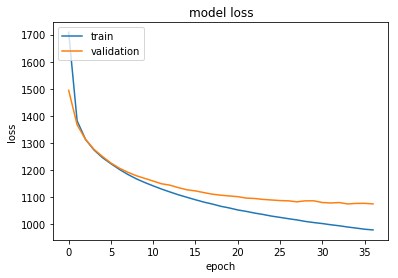

Test MSE:  1141.995272802972
Test MAE:  12.899635494178542 

Results for model:  2 



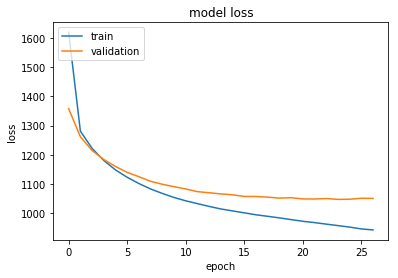

Test MSE:  1124.5845788795123
Test MAE:  13.370739080964048 

Results for model:  3 



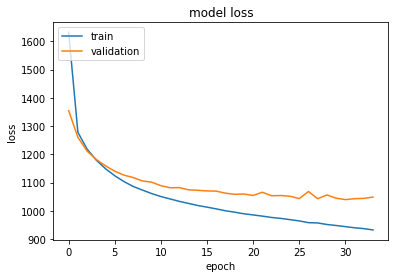

Test MSE:  1141.255510131439
Test MAE:  13.579944546795234 

SAMPLE DATA
Actual	 Model 1 Prediction	 Model 2 Prediction	 Model 3 Prediction	
98.0 	 84.26058 		 86.39358 		 83.37668 

24.0 	 28.362635 		 34.47313 		 35.86448 

68.0 	 77.836815 		 63.145313 		 76.45101 

38.0 	 38.84139 		 35.377316 		 35.849197 

26.0 	 20.591122 		 31.600594 		 25.05265 

22.0 	 22.694153 		 26.281837 		 25.950684 

15.0 	 22.50017 		 21.959805 		 22.527153 

12.0 	 18.67806 		 16.7112 		 11.182672 

25.0 	 22.023197 		 20.858475 		 18.970558 

40.0 	 31.238073 		 30.464008 		 30.31108 

25.0 	 20.429182 		 17.428871 		 17.000938 

20.0 	 17.56041 		 19.404667 		 16.847946 

45.0 	 30.212835 		 32.540287 		 28.607475 

20.0 	 23.079685 		 17.604946 		 18.688309 

30.0 	 35.713364 		 41.159313 		 40.657215 

13.0 	 17.704117 		 13.871768 		 14.491464 

15.0 	 31.783463 		 24.641483 		 32.955513 

20.0 	 31.086563 		 27.162975 		 24.123642 

53.0 	 44.038662 		 48.39953 		 53.347305 

14.0 	 29.06331 		 

In [29]:
for i in np.arange(3):
  print("Results for model: ", i+1,"\n")
  plot_losses(model_history[i])
  print("Test MSE: ", mean_squared_error(labels_test, model_predictions[i]))
  print("Test MAE: ", mean_absolute_error(labels_test, model_predictions[i]),'\n')

# Print some example predictions
num_predict = 30
np.random.seed(RANDOM_SEED)
print("SAMPLE DATA")
print('Actual\t', 'Model 1 Prediction\t', 'Model 2 Prediction\t','Model 3 Prediction\t')
for i in np.random.randint(len(test_seqs_padded), size = num_predict):
    print(labels_test.iloc[i],'\t', model_predictions[0][i][0],'\t\t', model_predictions[1][i][0],'\t\t', model_predictions[2][i][0],'\n')
      
  